# 📂 Veri Yükleme ve Ön İşleme

Bu bölümde **Intel Image Classification** veri seti yükleniyor.  
- `ImageDataGenerator` ile resimler **yeniden ölçekleniyor (1./255)**.  
- **Veri artırma (augmentation)** işlemleri uygulanıyor: rotation, shift, zoom, horizontal flip.  
- Eğitim verisi %80, doğrulama verisi %20 oranında ayrılıyor.  
- Örnek görseller görselleştiriliyor.


2025-09-25 15:13:00.763771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758813181.012922      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758813181.082593      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


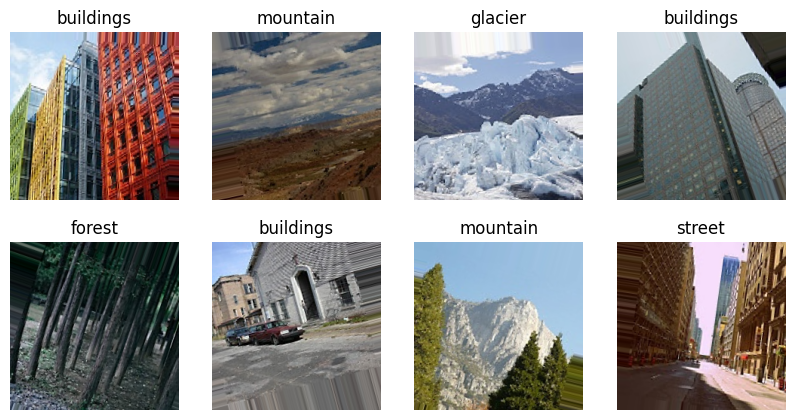

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH = 32

# Augmentation + validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)

# sınıf isimlerini al
classes = list(train_gen.class_indices.keys())

# birkaç örnek görsel çizelim
images, labels = next(train_gen)
plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")
plt.show()


# ⚙️ TensorFlow `tf.data` ile Dataset Hazırlığı

- Daha verimli eğitim için `image_dataset_from_directory` kullanıldı.  
- `training`, `validation` ve `test` datasetleri oluşturuldu.  
- GPU üzerinde **önbellekleme (cache), shuffle, prefetch** işlemleri yapıldı.  
- `data_augmentation` katmanı ile eğitim sırasında resimlere dönüşüm uygulanıyor.


In [2]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH = 64   # VRAM’e göre 64 veya 128 yapabilirsin
AUTOTUNE = tf.data.AUTOTUNE

# GPU üzerinde augmentation + normalize
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# --- Train dataset ---
raw_train = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH
)
class_names = raw_train.class_names   # sınıf isimleri

train_gen = raw_train.map(lambda x, y: (data_augmentation(x), y),
                          num_parallel_calls=AUTOTUNE)
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# --- Validation dataset ---
val_gen = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH
).cache().prefetch(buffer_size=AUTOTUNE)

# --- Test dataset ---
test_gen = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_test/seg_test",
    image_size=IMG_SIZE,
    batch_size=BATCH
).cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Dataset hazır, sınıflar:", class_names)

I0000 00:00:1758813200.306278      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758813200.307057      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
✅ Dataset hazır, sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# 🏷️ Sınıf İsimleri

Veri setindeki sınıflar listeleniyor. Bu proje kapsamında **6 farklı sınıf** bulunuyor.


In [3]:
# sınıf isimlerini görmek için
class_names = raw_train.class_names
print("Sınıflar:", class_names)

Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# 🔥 Transfer Learning: MobileNetV2

- **MobileNetV2** tabanlı bir model kullanıldı.  
- ImageNet ile önceden eğitilmiş ağırlıklar yüklendi.  
- **Base model dondurularak (freeze)** sadece üst katmanlar eğitildi.  
- `GlobalAveragePooling2D` ve `Dropout` eklenerek aşırı öğrenme (overfitting) azaltıldı.  
- Çıkış katmanı sınıf sayısına göre `softmax` ile ayarlandı.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# class_names zaten raw_train.class_names ile alınmış olmalı
num_classes = len(class_names)   # ✅ güvenli yol

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # transfer learning: temel katmanlar donduruldu

inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)   # ✅ düzeltildi

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 🔧 Fine-Tuning

- İlk eğitimden sonra modelin son katmanları yeniden açıldı.  
- Son **30–50 katman** eğitime dahil edilerek doğruluk artırıldı.  
- Daha düşük öğrenme oranı (lr=1e-5) kullanıldı.


In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# Fine-tuning ayarı
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Üst katmanlar
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# ✅ Hata yok artık
num_classes = len(class_names)   
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 1,534,086 (5.85 MB)

 Non-trainable params: 731,584 (2.79 MB)

# ⏹️ Callback Mekanizmaları

Eğitim sırasında performansı artırmak için:  
- **EarlyStopping**: Val. loss artarsa eğitim erken durur.  
- **ModelCheckpoint**: En iyi model ağırlıkları kaydedilir.  
- **ReduceLROnPlateau**: Öğrenme oranı otomatik düşürülür.


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

# 🏋️ Model Eğitimi

- **Phase 1 (Head Training)**: Base model tamamen donduruldu, yalnızca üst katmanlar eğitildi.  
- **Phase 2 (Fine-Tuning)**: Base modelin son katmanları açılarak daha derin eğitim yapıldı.  
- Epoch sayısı: Phase 1 → 3–5, Phase 2 → 10–15.


In [7]:
from tensorflow.keras import layers, models

# ---- Model ----
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# === Phase 1: Head Training ===
base_model.trainable = False   # önce freeze

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),   # hızlı öğrenme
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("=== Phase 1: Head Training Başlıyor ===")
history_a = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=4,   # 3–5 epoch yeterli
    callbacks=callbacks
)

# === Phase 2: Fine-Tuning ===
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # küçük lr
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("=== Phase 2: Fine-Tuning Başlıyor ===")
history_b = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,   # uzun eğitim
    callbacks=callbacks
)

=== Phase 1: Head Training Başlıyor ===
Epoch 1/4


I0000 00:00:1758813269.787354      77 service.cc:148] XLA service 0x78687000b990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758813269.788263      77 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758813269.788286      77 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758813270.609726      77 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/176 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.0877 - loss: 2.6606

I0000 00:00:1758813276.505405      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 142ms/step - accuracy: 0.6233 - loss: 1.0049 - val_accuracy: 0.8963 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 2/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8698 - loss: 0.3584 - val_accuracy: 0.9077 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 3/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8883 - loss: 0.3094 - val_accuracy: 0.9070 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 4/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8889 - loss: 0.2972 - val_accuracy: 0.9013 - val_loss: 0.2748 - learning_rate: 0.0010
=== Phase 2: Fine-Tuning Başlıyor ===
Epoch 1/12


E0000 00:00:1758813353.328918      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758813353.469855      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


176/176 ━━━━━━━━━━━━━━━━━━━━ 52s 157ms/step - accuracy: 0.7822 - loss: 0.5955 - val_accuracy: 0.9073 - val_loss: 0.2688 - learning_rate: 1.0000e-05
Epoch 2/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.8789 - loss: 0.3475 - val_accuracy: 0.9127 - val_loss: 0.2621 - learning_rate: 1.0000e-05
Epoch 3/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.8977 - loss: 0.2824 - val_accuracy: 0.9163 - val_loss: 0.2499 - learning_rate: 1.0000e-05
Epoch 4/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.9208 - loss: 0.2373 - val_accuracy: 0.9187 - val_loss: 0.2422 - learning_rate: 1.0000e-05
Epoch 5/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9325 - loss: 0.2002 - val_accuracy: 0.9216 - val_loss: 0.2369 - learning_rate: 1.0000e-05
Epoch 6/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.9431 - loss: 0.1709 - val_accuracy: 0.9237 - val_loss: 0.2328 - learning_rate: 1.0000e-05
Epoch 7/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accura

# 📊 Eğitim Süreci Grafikleri

- **Loss (kayıp)** ve **Accuracy (doğruluk)** grafikleri çizildi.  
- Phase 1 ve Phase 2 sonuçları ayrı ayrı gösterildi.  
- Eğitim & doğrulama performansları karşılaştırıldı.


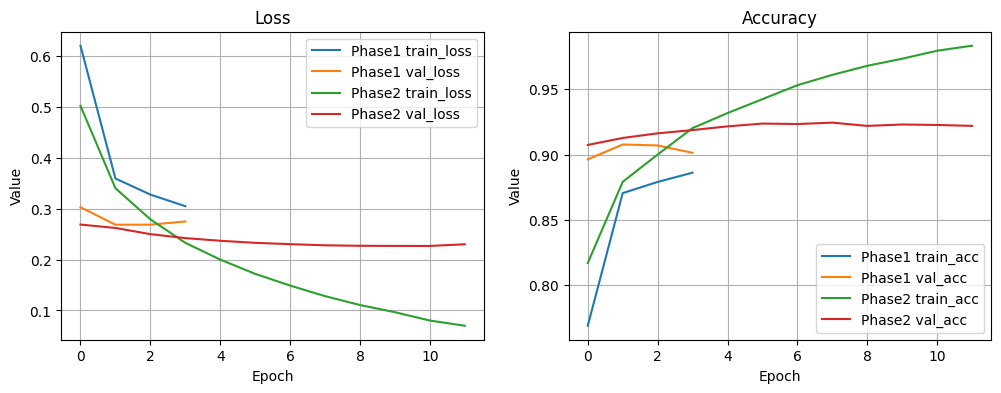

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Loss grafiği
plt.subplot(1,2,1)
plt.plot(history_a.history['loss'], label="Phase1 train_loss")
plt.plot(history_a.history['val_loss'], label="Phase1 val_loss")
plt.plot(history_b.history['loss'], label="Phase2 train_loss")
plt.plot(history_b.history['val_loss'], label="Phase2 val_loss")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.legend(); plt.grid(True)

# Accuracy grafiği
plt.subplot(1,2,2)
plt.plot(history_a.history['accuracy'], label="Phase1 train_acc")
plt.plot(history_a.history['val_accuracy'], label="Phase1 val_acc")
plt.plot(history_b.history['accuracy'], label="Phase2 train_acc")
plt.plot(history_b.history['val_accuracy'], label="Phase2 val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.legend(); plt.grid(True)

plt.show()

# ✅ Modelin Test Seti Üzerinde Değerlendirilmesi

Bu adımda eğitilen model test seti ile değerlendirilmiştir:  

- **Test Accuracy** değeri hesaplanır.  
- Modelin sınıflar üzerindeki başarımı **Classification Report** ile raporlanır  
  (Precision, Recall, F1-score ve Support değerleri).  
- **Confusion Matrix (Karmaşıklık Matrisi)** görselleştirilir:  
  - Satırlar gerçek etiketleri,  
  - Sütunlar modelin tahmin ettiği etiketleri gösterir.  
  - Hangi sınıflarda hata yaptığı açıkça görülür.  


Test Accuracy: 0.9193
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step

Classification Report:

              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.88      0.86      0.87       553
    mountain       0.86      0.86      0.86       525
         sea       0.95      0.97      0.96       510
      street       0.91      0.94      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



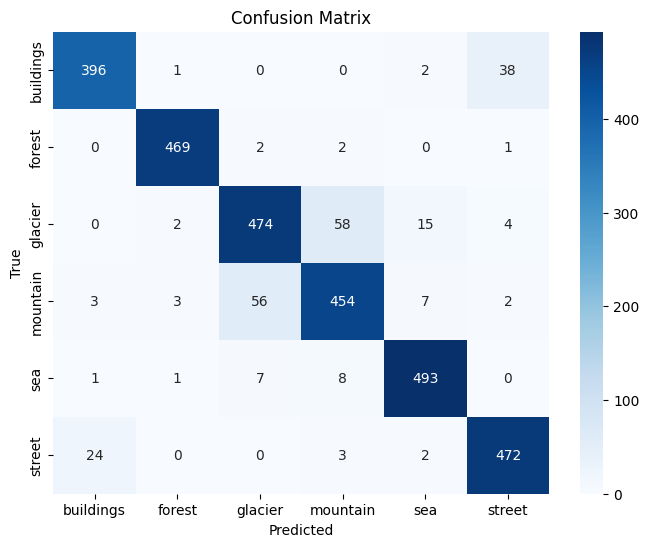

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Test setinde değerlendirme
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Tahminler
y_pred = np.argmax(model.predict(test_gen), axis=1)

# ✅ Gerçek label'ları tf.data'dan çekiyoruz
y_true = np.concatenate([y for x, y in test_gen], axis=0)

# ✅ class isimleri raw_train.class_names'ten
class_labels = class_names

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 🔍 Grad-CAM Görselleştirme

- Grad-CAM yöntemi ile modelin karar verirken hangi bölgeleri dikkate aldığı görselleştirildi.  
- Böylece modelin “neden bu tahmini yaptığı” daha açıklanabilir hale geldi.


In [10]:
def display_gradcam(img_path, model, last_conv_layer_name, alpha=0.4):
    # Görseli yükle
    img = tf.keras.utils.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # ✅ MobilenetV2 için preprocess
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Grad-CAM modeli
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:,:,i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Görseli göster
    import cv2, matplotlib.pyplot as plt
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.show()

# 📊 Veri Seti Sınıf Dağılımı

- Eğitim setindeki her sınıfa ait görsel sayıları hesaplandı.  
- Bar grafiği ile **sınıf dengesizliği** olup olmadığı kontrol edildi.


In [11]:
import pandas as pd
from tensorflow.keras.models import clone_model

results = []

# sınıf sayısını sabitle
num_classes = len(class_names)

# Base model template (bir kere yükle, döngüde kopyala)
base_template = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3), include_top=False, weights="imagenet"
)
base_template.trainable = False

for lr in [1e-3, 1e-4]:
    for dropout in [0.3, 0.5]:
        for opt_name in ["adam", "sgd"]:

            # Optimizer seç
            if opt_name == "adam":
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            else:
                optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

            # Base model kopyala
            base_model = clone_model(base_template)
            base_model.set_weights(base_template.get_weights())
            base_model.trainable = False

            # Model kur
            inputs = tf.keras.Input(shape=(224,224,3))
            x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
            x = base_model(x, training=False)
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
            x = tf.keras.layers.Dropout(dropout)(x)
            outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

            model = tf.keras.Model(inputs, outputs)
            model.compile(optimizer=optimizer,
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])

            # Eğit (🔥 hızlı deneme: 1 epoch + sınırlı step)
            history = model.fit(train_gen,
                                validation_data=val_gen,
                                epochs=1,
                                steps_per_epoch=10,   # sadece 10 batch
                                validation_steps=5,   # sadece 5 batch
                                verbose=0)

            val_acc = history.history['val_accuracy'][-1]
            results.append([lr, dropout, opt_name, val_acc])

# Tablo çıktısı
df_results = pd.DataFrame(results,
                          columns=["Learning Rate", "Dropout", "Optimizer", "Val Accuracy"])
print("\n=== Hiperparametre Denemeleri ===\n")
print(df_results)


=== Hiperparametre Denemeleri ===

   Learning Rate  Dropout Optimizer  Val Accuracy
0         0.0010      0.3      adam      0.578125
1         0.0010      0.3       sgd      0.121875
2         0.0010      0.5      adam      0.593750
3         0.0010      0.5       sgd      0.153125
4         0.0001      0.3      adam      0.221875
5         0.0001      0.3       sgd      0.184375
6         0.0001      0.5      adam      0.115625
7         0.0001      0.5       sgd      0.162500


# 📈 ROC Eğrileri

- Çok sınıflı sınıflandırma için ROC eğrileri çizildi.  
- Her sınıf için AUC (Area Under Curve) değeri raporlandı.  
- Modelin sınıflar üzerindeki ayırt edici gücü değerlendirildi.


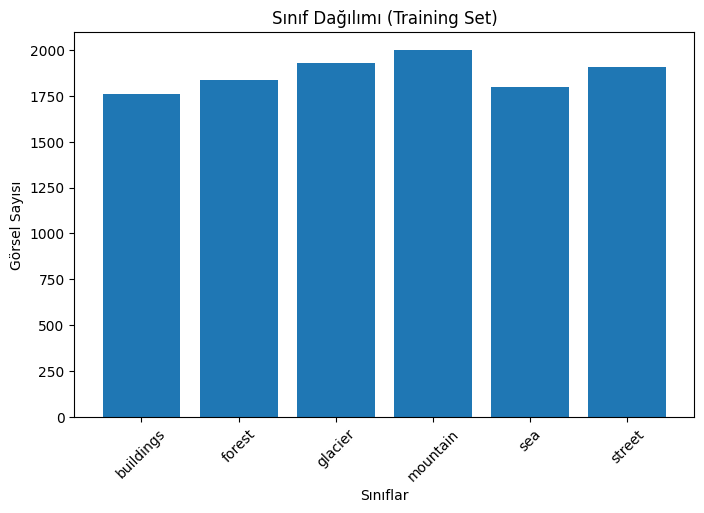

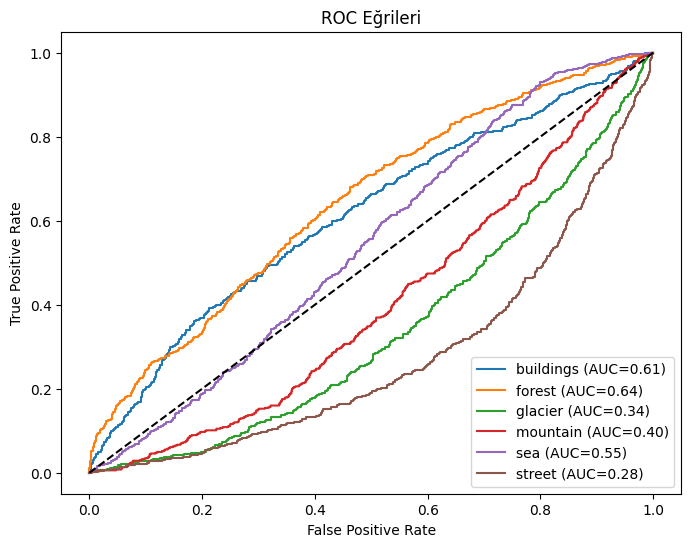

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# raw_train içinden label'ları çek
y_train = np.concatenate([labels.numpy() for _, labels in raw_train], axis=0)
counts = {class_names[i]: int((y_train == i).sum()) for i in range(num_classes)}

plt.figure(figsize=(8,5))
plt.bar(list(counts.keys()), list(counts.values()))
plt.title("Sınıf Dağılımı (Training Set)")
plt.xlabel("Sınıflar"); plt.ylabel("Görsel Sayısı")
plt.xticks(rotation=45)
plt.show()






from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Gerçek etiketler ve tahmin olasılıkları
y_true = np.concatenate([y for _, y in test_gen], axis=0)
y_prob = model.predict(test_gen, verbose=0)

# One-hot (ROC için gerekir)
y_true_bin = label_binarize(y_true, classes=range(num_classes))

plt.figure(figsize=(8,6))
for i, cname in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# 🔧 Phase-2 Ekstra Fine-Tuning

- MobileNetV2’nin son 50 katmanı daha ince ayarla eğitildi.  
- Düşük öğrenme oranı ve gelişmiş callback’ler kullanıldı.  
- Test seti üzerinde güncel doğruluk ölçülerek önceki sonuçlarla kıyaslandı.


In [13]:
# === Phase-2 Fine-Tuning (doğruluğu artır) ===

# MobileNetV2 gövdesini bul
base = None
for layer in model.layers:
    if "mobilenetv2" in layer.name:
        base = layer
        break

assert base is not None, "MobileNetV2 gövdesi bulunamadı."

# Son ~50 katmanı eğitime aç (daha fazla açmak istersen sayıyı artırabilirsin)
for l in base.layers[:-50]:
    l.trainable = False
for l in base.layers[-50:]:
    l.trainable = True

# Düşük LR ile model compile et (label smoothing YOK)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks_ft = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint("best_ft.h5", monitor="val_loss", save_best_only=True)
]

# Fine-tuning eğitimi
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_ft
)

# Güncel test performansı
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Fine-tuning sonrası Test Accuracy: {test_acc:.4f}")

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 158ms/step - accuracy: 0.3218 - loss: 1.8282 - val_accuracy: 0.6148 - val_loss: 1.0454 - learning_rate: 1.0000e-05
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.7118 - loss: 0.7885 - val_accuracy: 0.7331 - val_loss: 0.7518 - learning_rate: 1.0000e-05
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.8106 - loss: 0.5374 - val_accuracy: 0.7840 - val_loss: 0.6108 - learning_rate: 1.0000e-05
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.8517 - loss: 0.4144 - val_accuracy: 0.8264 - val_loss: 0.4760 - learning_rate: 1.0000e-05
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.8686 - loss: 0.3605 - val_accuracy: 0.8564 - val_loss: 0.4068 - learning_rate: 1.0000e-05
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.8909 - loss: 0.3068 - val_accuracy: 0.8756 - val_loss: 0.3545 - learning_rate: 1.0000e-05
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/st